<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_04_Understanding_Turbulence_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 04: Understanding Turbulence Signals

### In this section you will:


*   Learn about Turbulence and its use in investment management
*   Use a matrix of currency returns to calculate turbulence.
*   Explore the time series properties of turbulence

### Intro

Turbulence is a heuristic measure of volatility made popular by Chow et al. (1999) in "[Optimal Portfolios in Good Times and Bad](https://doi.org/10.2469/faj.v55.n3.2273)" based on the distance metric proposed by Mahalanobis in "[On the generalised distance in statistics](http://insa.nic.in/writereaddata/UpLoadedFiles/PINSA/Vol02_1936_1_Art05.pdf)".

In statistical terms, the metric $d_t$ describes how abnormal a set of returns are by comparing them against a normal approximation of the historic distribution of returns:

\begin{equation*}
d_t = \left( r_t - \mathbf{\mu} \right) \mathbf{\Sigma}^{-1} \left( r_t - \mathbf{\mu} \right)'
\end{equation*}

Where $\mathbf{\Sigma}$ and $\mathbf{\mu}$ are the covariance and mean return measured over the past $n$ days.

## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   DateTime (For basic date manipulation)
*   Matplotlib (For timeseries vizualization)

If the packages are not available, install the with "pip install X"

In [0]:
import numpy as np, pandas as pd
import statistics
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt

### Read in data from previously stored returns.pkl file



In [0]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### Calculate a covariance and mean of returns
For now, we will calcualte turbulence using the full sample covariance and mean.

df.cov() and df.mean() are needed.

In [0]:
retcov = returns.cov()
retcov

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
AUD,0.000052,0.000015,0.000016,0.000017,0.000017,0.000007,0.000020,0.000037,0.000019
CAD,0.000015,0.000020,0.000007,0.000009,0.000009,0.000002,0.000011,0.000014,0.000011
CHF,0.000016,0.000007,0.000051,0.000038,0.000026,0.000023,0.000032,0.000017,0.000030
EUR,0.000017,0.000009,0.000038,0.000039,0.000026,0.000019,0.000032,0.000019,0.000032
GBP,0.000017,0.000009,0.000026,0.000026,0.000036,0.000012,0.000024,0.000018,0.000023
JPY,0.000007,0.000002,0.000023,0.000019,0.000012,0.000043,0.000015,0.000009,0.000014
NOK,0.000020,0.000011,0.000032,0.000032,0.000024,0.000015,0.000044,0.000020,0.000034
NZD,0.000037,0.000014,0.000017,0.000019,0.000018,0.000009,0.000020,0.000059,0.000020
SEK,0.000019,0.000011,0.000030,0.000032,0.000023,0.000014,0.000034,0.000020,0.000044


In [0]:
retmean = returns.mean()
retmean

AUD   -0.000021
CAD   -0.000013
CHF    0.000110
EUR    0.000053
GBP   -0.000032
JPY    0.000108
NOK   -0.000020
NZD   -0.000026
SEK   -0.000042
dtype: float64

### Calculate turbulence by demeaning and applying inverse covariance matrix

np.linalg.pinv is a quick way of calculating the inverse of a covariance matrix.
np.einsum is a useful tool for matrix algebra. einsum('ij,ij->i',A, B) calculates the sumproduct of rows of A and B.

In [66]:
retinvcov = np.linalg.pinv(retcov)
turbulence = pd.DataFrame(np.einsum('ij,ij->i',(returns - retmean),(returns-retmean)@retinvcov),index=returns.index,columns=['daily'])
turbulence.head()

,daily
1975-01-02,4.395193
1975-01-03,3.027115
1975-01-06,10.848104
1975-01-07,3.508664
1975-01-08,7.552612


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7d4283048>],
      dtype=object)

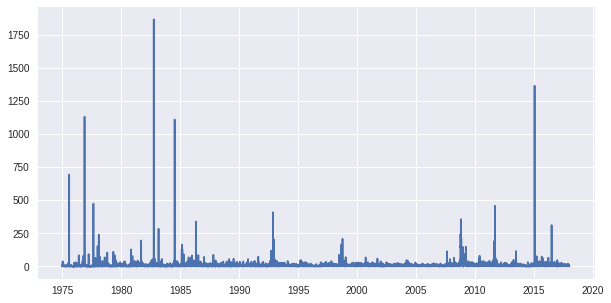

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
turbulence.plot(subplots=True, ax=axes, sharex=False, sharey=False, legend=False)

### Demonstrate that contemporaneously turbulence is concurrrent with high index volatility



In [0]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = returns.dot(dxy_weight)

In [97]:
highturbulence = turbulence['daily']>np.percentile(turbulence['daily'],80)
pd.DataFrame([[np.sqrt(261)*dxy[highturbulence].std(), np.sqrt(261)*dxy[~highturbulence].std()], [sum(highturbulence), sum(~highturbulence)]], index=['std','N'], columns=['High Turb','Low Turb'])

,High Turb,Low Turb
std,0.122616,0.057833
N,2243.000000,8971.000000


### Demonstrate that turbulence leads to persistently high volatility days

In [123]:
leading_dxy = pd.DataFrame([dxy.shift(-i) for i in range(0, 11)]).T
subsequent_vol = pd.DataFrame([leading_dxy[highturbulence].std(), leading_dxy[~highturbulence].std()],index=['High Turb','Low Turb']).T
subsequent_vol

,High Turb,Low Turb
0,0.007590,0.003580
1,0.005493,0.004446
2,0.005453,0.004458
3,0.005319,0.004499
4,0.005441,0.004461
5,0.005424,0.004467
6,0.005321,0.004499
7,0.005109,0.004560
8,0.005221,0.004529
9,0.005095,0.004565


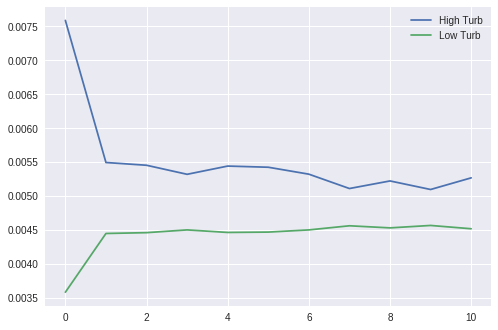

In [124]:
subsequent_vol.plot()